<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

Host: deeplearning-vm
You are here: /home/silpasoninallacheruvu/DD2424-project
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Train model

In [ ]:
from dataclasses import asdict
from util import json_dumps
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
%reload_ext autoreload
%autoreload 2

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import

from training import TrainParams, NagParams, AdamParams

baseline_params = TrainParams(
    seed=determinism.seed,
    batch_size=32,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.01,
        weight_decay=1e-4,
        momentum=0.9,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    validation_freq=1,
    unfreeze_last_l_blocks = 1,
    time_limit_seconds=None,
    val_acc_target=None,
)

invalidate_cache_entry = True
if invalidate_cache_entry:
    run.call_and_shelve(baseline_params).clear()

# First plot: Training and validation accuracy
for l in range(1,6):
    baseline_params.unfreeze_last_l_blocks = l
    print("Training with params:")
    print(baseline_params.pprint())
    result = run(baseline_params)

    print("Training result:")
    print(result.pprint())
    evaluate_with_train_val_plot(result)

    # Second plot: Rerun training multiple times with different seed
    run_with_different_seeds(baseline_params, trials=3)

    # Third plot: Compare NAG with Adam
    experimental_params = baseline_params.copy()
    experimental_params.optimizer = AdamParams(learning_rate=0.001)
    
    param_sets = {
        "Baseline (NAG)": baseline_params,
        "Experiment (Adam)": experimental_params,
    }
    
    run_comparison(param_sets, trials=3)


# Train unsupervised model

labelled_data_fraction: 0.5
Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.1303, Train Acc: 63.25%, Val Acc: 86.82%
Epoch [2/10], Loss: 0.6949, Train Acc: 85.60%, Val Acc: 78.26%
Epoch [3/10], Loss: 0.1949, Train Acc: 95.11%, Val Acc: 87.91%
Epoch [4/10], Loss: 0.0786, Train Acc: 98.10%, Val Acc: 91.03%
Epoch [5/10], Loss: 0.0296, Train Acc: 99.46%, Val Acc: 91.03%
Epoch [6/10], Loss: 0.0146, Train Acc: 99.80%, Val Acc: 91.98%
Epoch [7/10], Loss: 0.0136, Train Acc: 99.66%, Val Acc: 91.30%
Epoch [8/10], Loss: 0.0125, Train Acc: 99.73%, Val Acc: 91.98%
Epoch [9/10], Loss: 0.0052, Train Acc: 100.00%, Val Acc: 92.39%
Epoch [10/10], Loss: 0.0033, Train Acc: 100.00%, Val Acc: 92.66%
Total elapsed: 144.52s, average per update step: 0.26s
[Trainer] Saved checkpoint to runs/checkpoints/228e2d1cc551a6c372dd66409d146f5a.pth
Training result:
{
  "training_losses": [2.130329314781272, 0.6949245742846119, 0.1949492983783231, 0.07858205175168974, 0.02958755495542984, 0.014622134558917225, 0.01363330323289594, 0.012471378926420584, 0.0051837131980826835

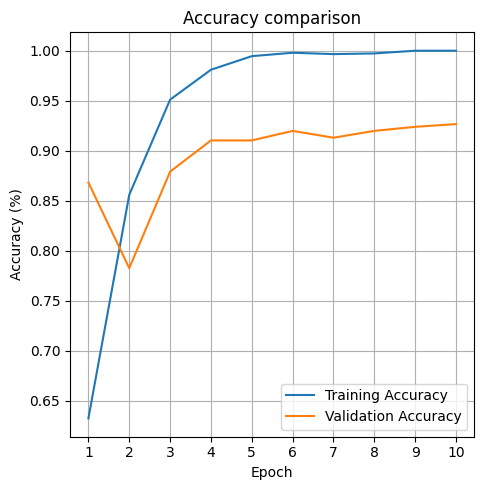

In [2]:
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import


dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    trainval_size=None,  # Load all training data
    #trainval_size=400,  # Load a subset
    validation_set_fraction=0.2,  # 20 % of trainval set
    labelled_data_fraction=1, # full labelled data first
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.022630885203465553,
        weight_decay=8.478660307897792e-05,
        momentum=0.8063799868511693,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
    unfreeze_last_l_blocks = 3
)

labelled_data_fraction = 0.5
print(f"labelled_data_fraction: {labelled_data_fraction}")
dataset_params.labelled_data_fraction = labelled_data_fraction

run_args = (dataset_params, baseline_params)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/10], Loss: 3.3502, Train Acc: 19.73%, Val Acc: 49.32%
Epoch [2/10], Loss: 2.2788, Train Acc: 66.33%, Val Acc: 64.81%
Epoch [3/10], Loss: 1.3661, Train Acc: 81.63%, Val Acc: 54.76%
Epoch [4/10], Loss: 0.8427, Train Acc: 85.71%, Val Acc: 79.48%
Epoch [5/10], Loss: 0.2846, Train Acc: 95.58%, Val Acc: 74.59%
Epoch [6/10], Loss: 0.1407, Train Acc: 97.96%, Val Acc: 73.78%
Epoch [7/10], Loss: 0.1244, Train Acc: 98.30%, Val Acc: 76.49%
Epoch [8/10], Loss: 0.1382, Train Acc: 99.32%, Val Acc: 76.36%
Epoch [9/10], Loss: 0.0823, Train Acc: 98.64%, Val Acc: 78.12%
Epoch [10/10], Loss: 0.0378, Train Acc: 99.32%, Val Acc: 79.21%
Total elapsed: 53.05s, average per update step: 0.26s
[Trainer] Saved checkpoint to runs/checkpoints/b96f4e69364ef4dfc2f3da20a8249d4e.pth
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.6773, Train Acc: 48.36%, Val Acc: 79.89%
Epoch [2/10], Loss: 0.9932, Train Acc: 81.43%, Val Acc: 80.84%
Epoch [3/10], Loss: 0.3257, Train Acc: 91.28%, Val Acc: 83.70%
Epoch [4/10], Loss: 0.1049, Train Acc: 97.62%, Val Acc: 87.50%
Epoch [5/10], Loss: 0.0405, Train Acc: 99.21%, Val Acc: 88.99%
Epoch [6/10], Loss: 0.0234, Train Acc: 99.55%, Val Acc: 90.22%
Epoch [7/10], Loss: 0.0323, Train Acc: 99.43%, Val Acc: 89.81%
Epoch [8/10], Loss: 0.0086, Train Acc: 99.89%, Val Acc: 90.35%
Epoch [9/10], Loss: 0.0143, Train Acc: 99.55%, Val Acc: 90.76%
Epoch [10/10], Loss: 0.0063, Train Acc: 99.89%, Val Acc: 90.49%
Total elapsed: 96.99s, average per update step: 0.25s
[Trainer] Saved checkpoint to runs/checkpoints/5337ae7f0e0ba4c3d5634086ce6b5a9b.pth
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/650 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.7914, Train Acc: 68.54%, Val Acc: 87.36%
Epoch [2/10], Loss: 0.5080, Train Acc: 86.41%, Val Acc: 84.92%
Epoch [3/10], Loss: 0.1798, Train Acc: 95.29%, Val Acc: 88.45%
Epoch [4/10], Loss: 0.0852, Train Acc: 97.38%, Val Acc: 90.76%
Epoch [5/10], Loss: 0.0281, Train Acc: 99.32%, Val Acc: 93.21%
Epoch [6/10], Loss: 0.0105, Train Acc: 99.90%, Val Acc: 93.48%
Epoch [7/10], Loss: 0.0115, Train Acc: 99.71%, Val Acc: 92.26%
Epoch [8/10], Loss: 0.0089, Train Acc: 99.90%, Val Acc: 91.17%
Epoch [9/10], Loss: 0.0178, Train Acc: 99.66%, Val Acc: 92.39%
Epoch [10/10], Loss: 0.0217, Train Acc: 99.37%, Val Acc: 91.71%
Total elapsed: 186.99s, average per update step: 0.26s
[Trainer] Saved checkpoint to runs/checkpoints/fb65dba6e9a9dae31524c1e67c7bd20f.pth
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/830 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.6094, Train Acc: 72.33%, Val Acc: 86.28%
Epoch [2/10], Loss: 0.4995, Train Acc: 86.37%, Val Acc: 85.87%
Epoch [3/10], Loss: 0.1246, Train Acc: 96.30%, Val Acc: 91.71%
Epoch [4/10], Loss: 0.0487, Train Acc: 98.72%, Val Acc: 93.75%
Epoch [5/10], Loss: 0.0211, Train Acc: 99.51%, Val Acc: 91.58%
Epoch [6/10], Loss: 0.0261, Train Acc: 99.36%, Val Acc: 92.53%
Epoch [7/10], Loss: 0.0195, Train Acc: 99.51%, Val Acc: 92.93%
Epoch [8/10], Loss: 0.0076, Train Acc: 99.92%, Val Acc: 93.48%
Epoch [9/10], Loss: 0.0200, Train Acc: 99.43%, Val Acc: 92.12%
Epoch [10/10], Loss: 0.0111, Train Acc: 99.81%, Val Acc: 91.71%
Total elapsed: 230.83s, average per update step: 0.27s
[Trainer] Saved checkpoint to runs/checkpoints/d689bfde36dace452506db997e74c2e3.pth
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/920 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.4610, Train Acc: 75.14%, Val Acc: 90.22%
Epoch [2/10], Loss: 0.2780, Train Acc: 91.30%, Val Acc: 89.95%
Epoch [3/10], Loss: 0.0799, Train Acc: 98.00%, Val Acc: 93.07%
Epoch [4/10], Loss: 0.0280, Train Acc: 99.52%, Val Acc: 93.75%
Epoch [5/10], Loss: 0.0125, Train Acc: 99.93%, Val Acc: 94.84%
Epoch [6/10], Loss: 0.0109, Train Acc: 99.83%, Val Acc: 94.29%
Epoch [7/10], Loss: 0.0083, Train Acc: 99.93%, Val Acc: 94.57%
Epoch [8/10], Loss: 0.0035, Train Acc: 100.00%, Val Acc: 95.38%
Epoch [9/10], Loss: 0.0032, Train Acc: 100.00%, Val Acc: 95.79%
Epoch [10/10], Loss: 0.0028, Train Acc: 100.00%, Val Acc: 95.24%
Total elapsed: 138.69s, average per update step: 0.11s
[Trainer] Saved checkpoint to runs/checkpoints/7f450cb80d886b6d93127528317f1730.pth


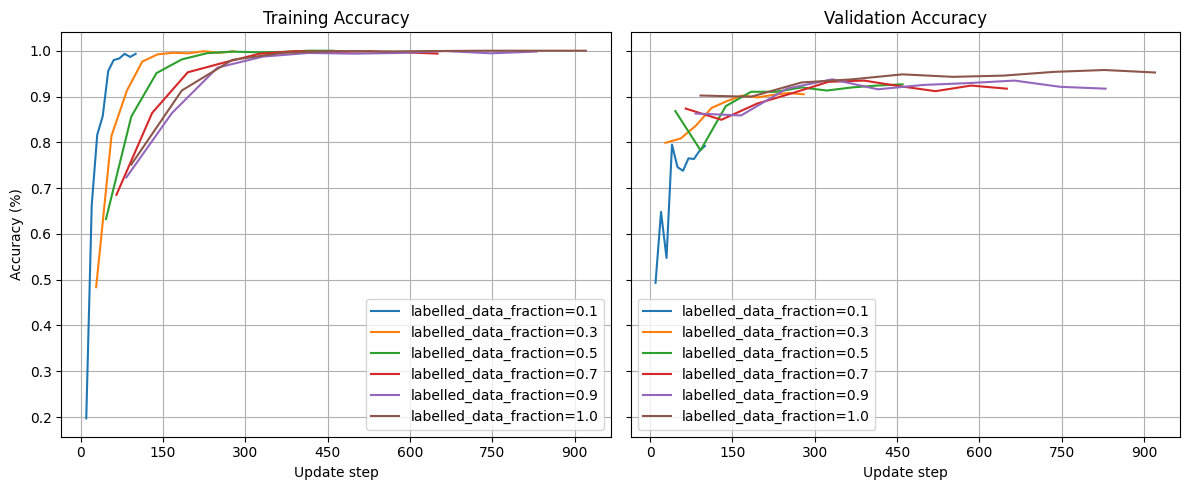

In [3]:
from evaluation import run_dataset_comparison
def tweak(params: DatasetParams, labelled_data_fraction):
    params = params.copy()
    params.labelled_data_fraction = labelled_data_fraction
    return params


#plot: Compare unsupervised learning for different fractions of unlabelled data
labelled_data_fractions = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
param_sets = {f"labelled_data_fraction={data_fraction}": tweak(dataset_params, labelled_data_fraction=data_fraction) for data_fraction in labelled_data_fractions}

run_dataset_comparison(param_sets, baseline_params)


# Test model

In [5]:
from training import FinishedAllEpochs, Trainer
from datasets import make_datasets, load_dataset
from torch.utils.data import DataLoader

training_params = baseline_params

print("Training with params:")
print(training_params.pprint())
trainer = Trainer(training_params)
labelled_train_loader, unlabelled_train_loader, val_loader = make_datasets(dataset_params, trainer.transform)
trainer.load_dataset(labelled_train_loader, unlabelled_train_loader, val_loader)
trainer.train(stop_condition=FinishedAllEpochs())

training_params.data_augmentation = "false"
test_dataset = load_dataset("test", Trainer.make_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    worker_init_fn=Determinism.data_loader_worker_init_fn(training_params.seed),
)
print(f"Test size: {len(test_loader.dataset)}")

evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 10,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "unfreeze_last_l_blocks": 3,
  "unsup_weight": 0.5,
  "psuedo_threshold": 0.95
}
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.1442, Train Acc: 62.57%, Val Acc: 86.96%
Epoch [2/10], Loss: 0.6611, Train Acc: 85.67%, Val Acc: 84.51%
Epoch [3/10], Loss: 0.1503, Train Acc: 95.52%, Val Acc: 89.54%
Epoch [4/10], Loss: 0.0517, Train Acc: 98.85%, Val Acc: 90.90%
Epoch [5/10], Loss: 0.0348, Train Acc: 99.12%, Val Acc: 89.67%
Epoch [6/10], Loss: 0.0242, Train Acc: 99.32%, Val Acc: 91.17%
Epoch [7/10], Loss: 0.0376, Train Acc: 99.12%, Val Acc: 89.13%
Epoch [8/10], Loss: 0.0177, Train Acc: 99.46%, Val Acc: 91.71%
Epoch [9/10], Loss: 0.0172, Train Acc: 99.80%, Val Acc: 89.81%
Epoch [10/10], Loss: 0.0061, Train Acc: 99.93%, Val Acc: 92.80%
Total elapsed: 142.13s, average per update step: 0.26s
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

(89.5611883346961,
 [(PosixPath('data/oxford-iiit-pet/images/Abyssinian_206.jpg'), 0, 5),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_207.jpg'), 0, 2),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_212.jpg'), 0, 27),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_215.jpg'), 0, 5),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_21.jpg'), 0, 11),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_225.jpg'), 0, 5),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_226.jpg'), 0, 5),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_26.jpg'), 0, 31),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_36.jpg'), 0, 21),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_50.jpg'), 0, 23),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_52.jpg'), 0, 5),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_75.jpg'), 0, 5),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_79.jpg'), 0, 27),
  (PosixPath('data/oxford-iiit-pet/images/Abyssinian_8.jpg'